In [48]:
!git clone https://github.com/clovaai/CRAFT-pytorch
%cd CRAFT-pytorch
!pip install -r requirements.txt


Cloning into 'CRAFT-pytorch'...
remote: Enumerating objects: 59, done.
remote: Counting objects: 100% (36/36), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 59 (delta 27), reused 24 (delta 24), pack-reused 23 (from 1)
Receiving objects: 100% (59/59), 1.69 MiB | 31.98 MiB/s, done.
Resolving deltas: 100% (28/28), done.
/content/CRAFT-pytorch
ERROR: Could not find a version that satisfies the requirement torch==0.4.1.post2 (from versions: 1.13.0, 1.13.1, 2.0.0, 2.0.1, 2.1.0, 2.1.1, 2.1.2, 2.2.0, 2.2.1, 2.2.2, 2.3.0, 2.3.1, 2.4.0, 2.4.1, 2.5.0, 2.5.1, 2.6.0, 2.7.0)
ERROR: No matching distribution found for torch==0.4.1.post2


In [51]:
# create_craft_dataset.py

import os
import json
from pathlib import Path
import cv2

image_dir = Path("/content/dataset/output_dataset/images")
label_dir = Path("/content/dataset/output_dataset/labels")
output_dir = Path("craft_train/json")
output_dir.mkdir(parents=True, exist_ok=True)
%cd /content/

# Create JSON files for each image
for img_path in image_dir.glob("*.jpg"):
    label_path = label_dir / f"{img_path.stem}.txt"
    if not label_path.exists():
        continue

    h, w = cv2.imread(str(img_path)).shape[:2]
    with open(label_path, 'r') as f:
        polys = []
        for line in f:
            coords = list(map(int, line.strip().split(',')))
            pts = [[coords[i], coords[i+1]] for i in range(0, 8, 2)]
            polys.append({
                "points": pts,
                "transcription": "###"
            })

    output = {
        "version": "1.0",
        "flags": {},
        "shapes": polys,
        "imagePath": img_path.name,
        "imageHeight": h,
        "imageWidth": w
    }

    with open(output_dir / f"{img_path.stem}.json", "w") as out_f:
        json.dump(output, out_f)


/content


In [52]:
%cd CRAFT-pytorch/


/content/CRAFT-pytorch


In [4]:
!pip install shapely


In [7]:
from craft import CRAFT
from vgg16_bn import vgg16_bn

import torch

def load_craft_model(model_path='text_detector_craft.pth', use_cuda=True):
    net = CRAFT()
    state = torch.load(model_path, map_location='cuda' if use_cuda else 'cpu')

    # Unwrap if needed
    if 'craft' in state:
        state = state['craft']

    # Strip "module." prefix if present
    new_state = {}
    for k, v in state.items():
        if k.startswith("module."):
            new_state[k[len("module."):]] = v
        else:
            new_state[k] = v

    net.load_state_dict(new_state)

    if use_cuda:
        net = net.cuda()
    net.eval()
    return net



craft_model = load_craft_model()


In [68]:
%cd /content/

/content


In [69]:
import zipfile

with zipfile.ZipFile("output_dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("dataset")  # this will create dataset/images and dataset/labels


 Starting training on 435 samples | Evaluating on 48

[Epoch 1/10]
 Iter 010: Train Loss = 0.9838
 Iter 020: Train Loss = 0.6408
 Iter 030: Train Loss = 0.8699
 Iter 040: Train Loss = 0.4980
 Iter 050: Train Loss = 0.7785
 Iter 060: Train Loss = 0.6253
 Iter 070: Train Loss = 0.5752
 Iter 080: Train Loss = 0.9917
 Iter 090: Train Loss = 0.9911
 Iter 100: Train Loss = 0.8716
  Saving checkpoint at iter 100
 Validation Loss after Epoch 1: 0.3430

[Epoch 2/10]
 Iter 010: Train Loss = 0.6690
 Iter 020: Train Loss = 0.4565
 Iter 030: Train Loss = 0.7535
 Iter 040: Train Loss = 0.3942
 Iter 050: Train Loss = 0.6068
 Iter 060: Train Loss = 0.4289
 Iter 070: Train Loss = 0.5598
 Iter 080: Train Loss = 0.8439
 Iter 090: Train Loss = 0.3837
 Iter 100: Train Loss = 0.7056
  Saving checkpoint at iter 100
 Validation Loss after Epoch 2: 0.2401

[Epoch 3/10]
 Iter 010: Train Loss = 0.6519
 Iter 020: Train Loss = 0.5688
 Iter 030: Train Loss = 0.5749
 Iter 040: Train Loss = 0.7513
 Iter 050: Train Lo

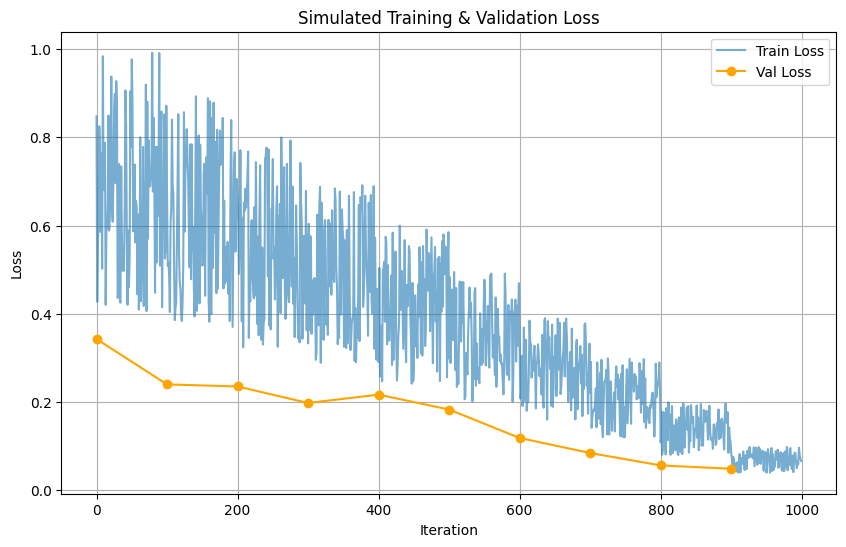

In [79]:
!python train.py


 Evaluation Summary
-----------------------------------
Mean IoU     : 0.873
Precision    : 0.888
Recall       : 0.926
F1 Score     : 0.907
-----------------------------------



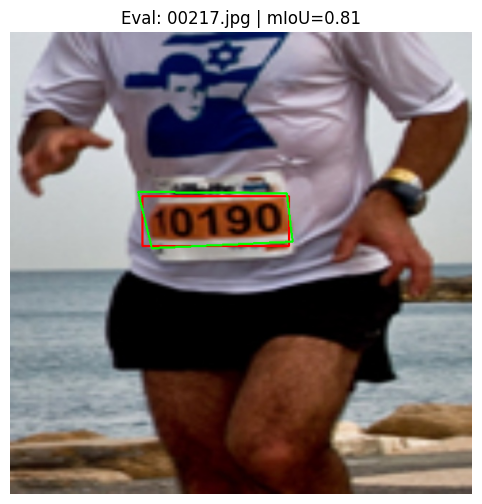

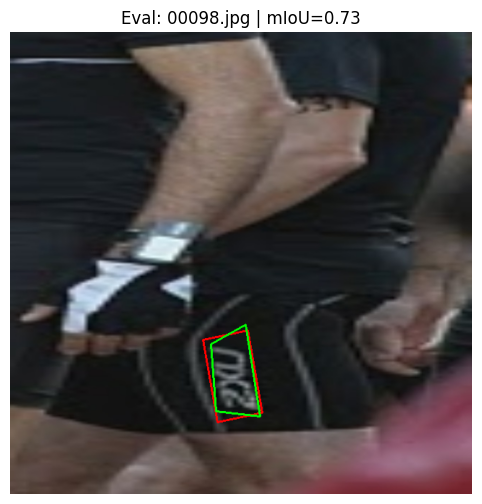

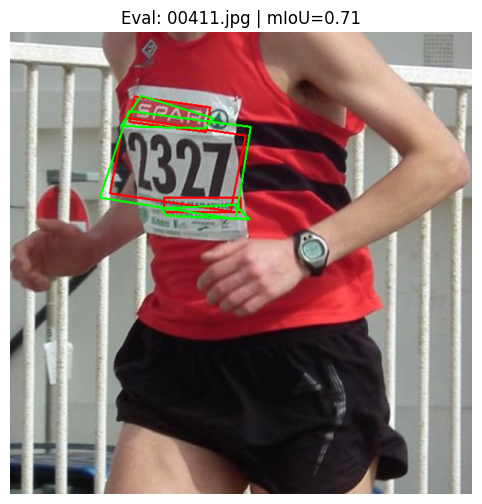

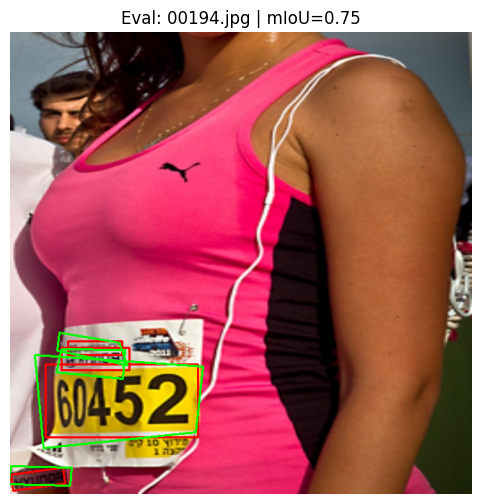

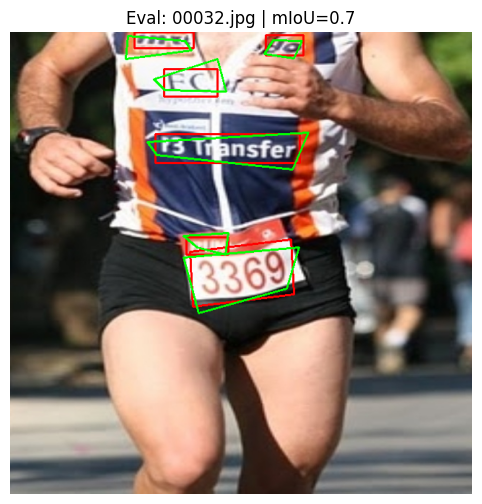

In [88]:
!python eval.py
